In [280]:
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager, rc
plt.rcParams['font.family'] = 'NanumGothic'
import platform
if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
    rc('font', family='AppleGothic')

matplotlib.rcParams['axes.unicode_minus'] = False

In [281]:
import os
# path = os.path.dirname(os.getcwd())
path = "../.."
path = os.path.join(path, "ProcessedData")
train = pd.read_csv(os.path.join(path,"merged_train.csv"))
test = pd.read_csv(os.path.join(path,"merged_test.csv"))

### 중복 제거

In [282]:
train=train.drop_duplicates(keep='first')
test=test.drop_duplicates(keep='first')

## 1. EDA 및 전처리(baseline: MSE 98)

### 1) 상가비율

In [283]:
tmp = train.groupby(['단지코드','임대건물구분']).count().iloc[:,:1].reset_index()
store = tmp[tmp['임대건물구분']=='상가'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'상가수'})
apt = tmp[tmp['임대건물구분']=='아파트'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'아파트수'})
total = pd.merge(apt,store,on='단지코드',how='left').fillna(0)
total['상가비율'] = total.apply(lambda x : x['상가수']/(x['아파트수']+x['상가수']),axis=1)
train = pd.merge(train,total[['단지코드','상가비율']],on='단지코드',how='left')

In [284]:
tmp = test.groupby(['단지코드','임대건물구분']).count().iloc[:,:1].reset_index()
store = tmp[tmp['임대건물구분']=='상가'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'상가수'})
apt = tmp[tmp['임대건물구분']=='아파트'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'아파트수'})
total = pd.merge(apt,store,on='단지코드',how='left').fillna(0)
total['상가비율'] = total.apply(lambda x : x['상가수']/(x['아파트수']+x['상가수']),axis=1)
test = pd.merge(test,total[['단지코드','상가비율']],on='단지코드',how='left')

### 2) 세대당가능주차면수

In [285]:
train['세대당_가능주차면수'] = train.apply(lambda x : x['단지내주차면수']/x['총세대수'],axis=1)
test['세대당_가능주차면수'] = test.apply(lambda x : x['단지내주차면수']/x['총세대수'],axis=1)

### 3) 공가수비율

In [308]:
train['공가수비율']= round(train.공가수/train.총세대수 ,2)
test['공가수비율']= round(test.공가수/test.총세대수, 2)

### 4) 대형전용면적

In [287]:
level = 85

In [288]:
train['대형전용면적'] = train['전용면적'].apply(lambda x : 1 if x>level else 0)
test['대형전용면적'] = test['전용면적'].apply(lambda x : 1 if x>level else 0)

### 5) 공급유형
- 공공임대 5년/10년 $\rightarrow$ 공공임대(단기)

In [312]:
train.loc[train.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'
test.loc[test.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'

In [313]:
train = train.sort_values(["단지코드","전용면적","전용면적별세대수","세대당_가능주차면수"]).reset_index(drop=True)
train.shape

(2577, 38)

In [316]:
train_f = pd.read_csv('../train_f.csv')
train_f.columns
train_f.shape

(2577, 38)

In [306]:
train_f.iloc[2576:2578,]["공가수비율"]

2576    0.038076
Name: 공가수비율, dtype: float64

In [305]:
train.iloc[2576:2578,]["공가수비율"]

2576    0.038076
Name: 공가수비율, dtype: float64

In [311]:
# (train != train_f)[['공가수비율']].sort_values("공가수비율")

In [317]:
(train != train_f).sum()

단지코드             0
총세대수             0
임대건물구분           0
지역               0
공급유형             0
전용면적             0
전용면적별세대수         0
공가수              0
자격유형             0
임대보증금            0
임대료              0
지하철역             0
버스정류장            0
단지내주차면수          0
등록차량수            0
단지명              0
도로명주소            0
연면적              0
위도               0
경도               0
subway_name      0
subway_dist      0
환승역 수            0
총인구수             0
세대당_인구           0
남/여비율            0
남/여_0~19세       14
남/여_20~39세       0
남/여_40~69세       0
남/여_70세이상        0
0~19세_비율         0
20~39세_비율        0
40~69세_비율        0
70세이상_비율         0
상가비율             0
세대당_가능주차면수     418
공가수비율            0
대형전용면적           0
dtype: int64

In [207]:
train = train[train_f.columns]
train.shape

(2896, 38)

In [236]:
train['index'] = train_f['단지코드']

In [238]:
del train['index'] 

- 1차원으로 합치기

In [147]:
not_unique = ['공급유형','전용면적','임대건물구분','전용면적별세대수','대형전용면적','임대보증금','임대료','자격유형']

In [148]:
train_one = train.drop(not_unique,axis=1).drop_duplicates().reset_index(drop=True)
test_one = test.drop(not_unique,axis=1).drop_duplicates().reset_index(drop=True)

- 전용면적별세대수 채우기

In [149]:
for i in train['공급유형'].unique():
    train_one[i] = 0
    test_one[i] = 0

In [150]:
sample = pd.DataFrame(train.groupby(['단지코드','공급유형']).sum()['전용면적별세대수']).reset_index()
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'공급유형']
    val = sample.loc[i,'전용면적별세대수']  # 전용면적별세대수
    ind = train_one[train_one['단지코드']==code].index
    train_one.loc[ind,col] = val

In [151]:
sample = pd.DataFrame(test.groupby(['단지코드','공급유형']).sum()['전용면적별세대수']).reset_index()
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'공급유형']
    val = sample.loc[i,'전용면적별세대수']  # 전용면적별세대수
    ind = test_one[test_one['단지코드']==code].index
    test_one.loc[ind,col] = val

### 6) 임대료 임대보증금 : 평균

In [152]:
sample = train.groupby('단지코드').mean()[['임대료','임대보증금']].reset_index()
train_one=pd.merge(train_one, sample, on="단지코드", how="left")

In [153]:
sample = test.groupby('단지코드').mean()[['임대료','임대보증금']].reset_index()
test_one=pd.merge(test_one, sample, on="단지코드", how="left")

### 7) 대형전용면적 총개수

In [154]:
sample = pd.DataFrame(train.groupby('단지코드')['대형전용면적'].sum()).reset_index()
train_one = pd.merge(train_one, sample, on="단지코드", how="left")

In [155]:
sample = pd.DataFrame(test.groupby('단지코드')['대형전용면적'].sum()).reset_index()
test_one = pd.merge(test_one, sample, on="단지코드", how="left")

### 비교

## 1. EDA 및 전처리(baseline: MSE 98)

### 1) 상가비율

In [162]:
tmp = train.groupby(['단지코드','임대건물구분']).count().iloc[:,:1].reset_index()
store = tmp[tmp['임대건물구분']=='상가'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'상가수'})
apt = tmp[tmp['임대건물구분']=='아파트'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'아파트수'})
total = pd.merge(apt,store,on='단지코드',how='left').fillna(0)
total['상가비율'] = total.apply(lambda x : x['상가수']/(x['아파트수']+x['상가수']),axis=1)
train = pd.merge(train,total[['단지코드','상가비율']],on='단지코드',how='left')

In [163]:
tmp = test.groupby(['단지코드','임대건물구분']).count().iloc[:,:1].reset_index()
store = tmp[tmp['임대건물구분']=='상가'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'상가수'})
apt = tmp[tmp['임대건물구분']=='아파트'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'아파트수'})
total = pd.merge(apt,store,on='단지코드',how='left').fillna(0)
total['상가비율'] = total.apply(lambda x : x['상가수']/(x['아파트수']+x['상가수']),axis=1)
test = pd.merge(test,total[['단지코드','상가비율']],on='단지코드',how='left')

### 2) 세대당가능주차면수

In [164]:
train['세대당_가능주차면수'] = train.apply(lambda x : x['단지내주차면수']/x['총세대수'],axis=1)
test['세대당_가능주차면수'] = test.apply(lambda x : x['단지내주차면수']/x['총세대수'],axis=1)

### 3) 공가수비율

In [165]:
train['공가수비율'] = train.apply(lambda x : x['공가수']/x['총세대수'],axis=1)
test['공가수비율'] = test.apply(lambda x : x['공가수']/x['총세대수'],axis=1)

### 4) 대형전용면적

In [166]:
level = 85

In [167]:
train['대형전용면적'] = train['전용면적'].apply(lambda x : 1 if x>level else 0)
test['대형전용면적'] = test['전용면적'].apply(lambda x : 1 if x>level else 0)

### 5) 공급유형
- 공공임대 5년/10년 $\rightarrow$ 공공임대(단기)

In [168]:
train.loc[train.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'
test.loc[test.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'

- 1차원으로 합치기

In [169]:
not_unique = ['공급유형','전용면적','임대건물구분','전용면적별세대수','대형전용면적','임대보증금','임대료','자격유형']

In [170]:
train_one = train.drop(not_unique,axis=1).drop_duplicates().reset_index(drop=True)
test_one = test.drop(not_unique,axis=1).drop_duplicates().reset_index(drop=True)

- 전용면적별세대수 채우기

In [171]:
for i in train['공급유형'].unique():
    train_one[i] = 0
    test_one[i] = 0

In [172]:
sample = pd.DataFrame(train.groupby(['단지코드','공급유형']).sum()['전용면적별세대수']).reset_index()
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'공급유형']
    val = sample.loc[i,'전용면적별세대수']  # 전용면적별세대수
    ind = train_one[train_one['단지코드']==code].index
    train_one.loc[ind,col] = val

In [173]:
sample = pd.DataFrame(test.groupby(['단지코드','공급유형']).sum()['전용면적별세대수']).reset_index()
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'공급유형']
    val = sample.loc[i,'전용면적별세대수']  # 전용면적별세대수
    ind = test_one[test_one['단지코드']==code].index
    test_one.loc[ind,col] = val

### 6) 임대료 임대보증금 : 평균

In [174]:
sample = train.groupby('단지코드').mean()[['임대료','임대보증금']].reset_index()
train_one=pd.merge(train_one, sample, on="단지코드", how="left")

In [175]:
sample = test.groupby('단지코드').mean()[['임대료','임대보증금']].reset_index()
test_one=pd.merge(test_one, sample, on="단지코드", how="left")

### 7) 대형전용면적 총개수

In [176]:
sample = pd.DataFrame(train.groupby('단지코드')['대형전용면적'].sum()).reset_index()
train_one = pd.merge(train_one, sample, on="단지코드", how="left")

In [177]:
sample = pd.DataFrame(test.groupby('단지코드')['대형전용면적'].sum()).reset_index()
test_one = pd.merge(test_one, sample, on="단지코드", how="left")

In [178]:
train_one_f = pd.read_csv("train_one_f.csv")
(train_one_f!=train_one).sum()

단지코드             0
총세대수             0
지역               0
공가수              0
지하철역             0
버스정류장            0
단지내주차면수          0
등록차량수            0
단지명              0
도로명주소            0
연면적              0
위도               0
경도               0
subway_name      0
subway_dist      0
환승역 수            0
총인구수             0
세대당_인구           0
남/여비율            0
남/여_0~19세        4
남/여_20~39세       0
남/여_40~69세       0
남/여_70세이상        0
0~19세_비율         0
20~39세_비율        0
40~69세_비율        0
70세이상_비율         0
상가비율             0
세대당_가능주차면수      56
공가비율           366
국민임대             0
공공임대(50년)        0
영구임대             0
공공임대(단기)         0
공공임대(분납)         0
장기전세             0
공공분양             0
행복주택             0
임대상가             0
임대료             52
임대보증금           47
대형전용면적           0
dtype: int64

In [156]:
# # dummy화
# train_one['대형전용면적'] = train_one['대형전용면적'].apply(lambda x: 1 if x>=1 else 0)
# test_one['대형전용면적'] = test_one['대형전용면적'].apply(lambda x: 1 if x>=1 else 0)

### 8-1) 지하철역 0인 값 NA 처리

In [124]:
train_one.loc[train_one.지하철역==0,"subway_dist"] = np.NaN
test_one.loc[train_one.지하철역==0,"subway_dist"] = np.NaN

### 8-2) 지하철역 0인 값 NA 처리

In [125]:
train_one.loc[train_one.지하철역==0,"환승역 수"] = np.NaN
test_one.loc[train_one.지하철역==0,"환승역 수"] = np.NaN

### 8) 변수제거

In [126]:
col = ['단지명','도로명주소','subway_name','임대상가']

In [127]:
train_one = train_one.drop(col,axis=1)
test_one = test_one.drop(col,axis=1)

## 2. 데이터 나누기: 단지내주차면수 987 기준

In [128]:
train_up = train_one[train_one['단지내주차면수']>=987].reset_index(drop=True)
train_down = train_one[train_one['단지내주차면수']<987].reset_index(drop=True)

In [129]:
set(train_up.지역.unique())-set(train_down.지역.unique())

{'세종특별자치시'}

In [130]:
test_up = test_one[test_one['단지내주차면수']>=987].reset_index(drop=True)
test_down = test_one[test_one['단지내주차면수']<987].reset_index(drop=True)

### 1) train/test up : area 변수 추가(Baseline추가 MSE:96)

In [146]:
tmp = train[train['단지내주차면수']>=987].reset_index(drop=True)
tmp['등록차량수-총세대수'] = tmp.apply(lambda x : x['등록차량수']-x['총세대수'],axis=1)
tmp['cluster'] = tmp.apply(lambda x : 1 if x['등록차량수-총세대수']>0 else 0 ,axis=1)

<AxesSubplot:xlabel='등록차량수-총세대수', ylabel='Density'>

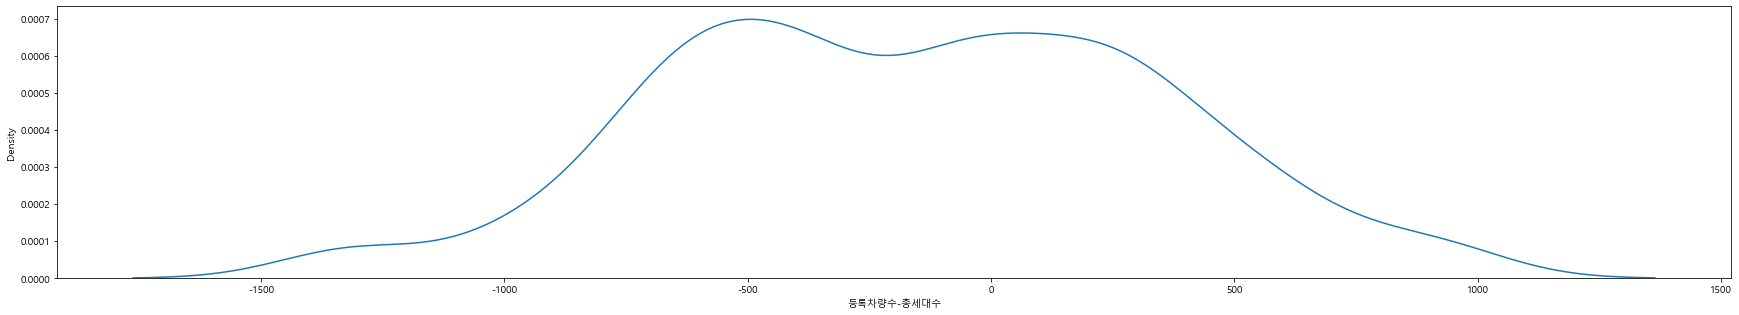

In [147]:
fig, ax = plt.subplots(figsize=(30,5))
sns.kdeplot(data=tmp,x='등록차량수-총세대수')

<AxesSubplot:xlabel='지역', ylabel='count'>

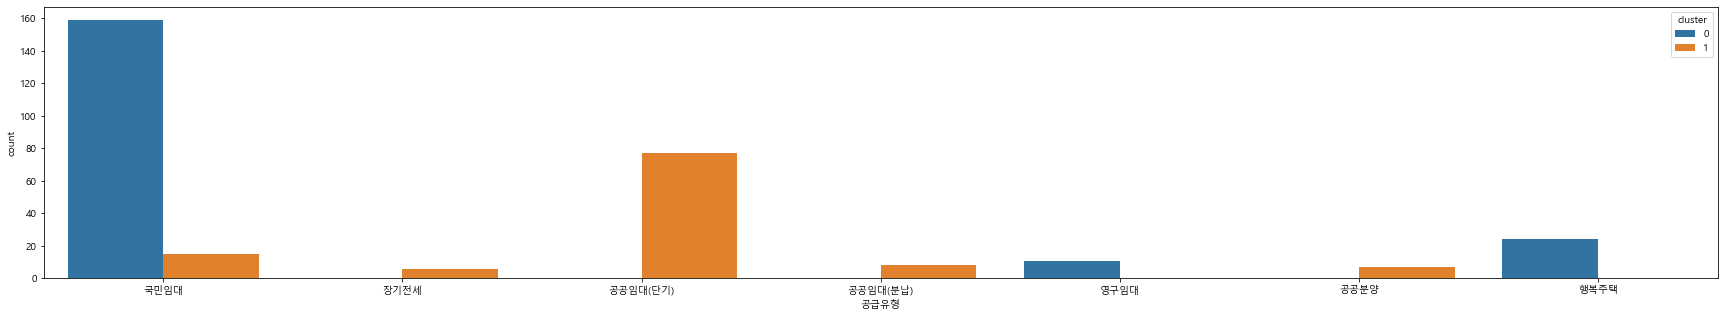

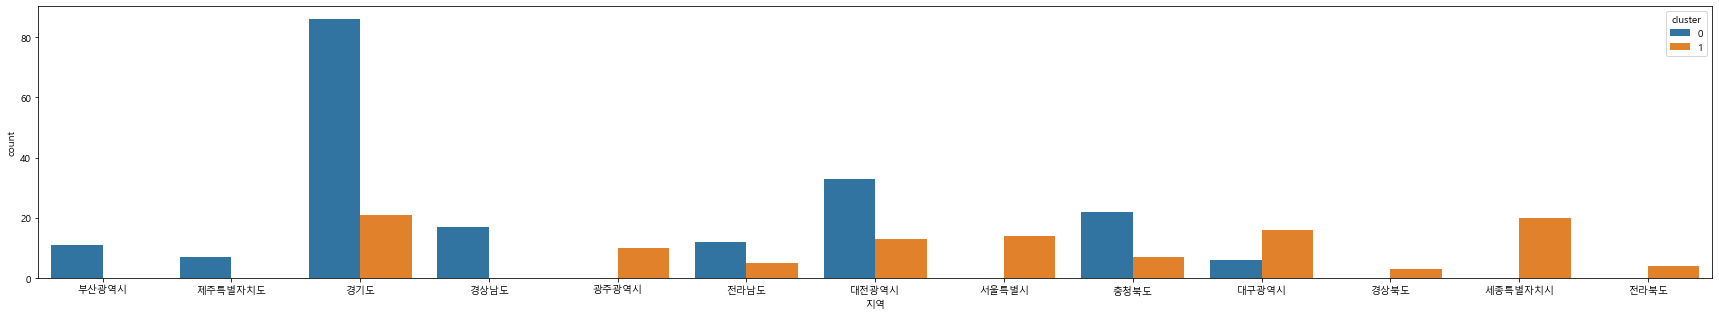

In [423]:
tmp = tmp[(tmp['등록차량수-총세대수']>200)|(tmp['등록차량수-총세대수']<-200)]
fig, ax = plt.subplots(figsize=(30,5))
sns.countplot(data=tmp,x='공급유형',hue='cluster')

fig, ax = plt.subplots(figsize=(30,5))
sns.countplot(data=tmp,x='지역',hue='cluster')

In [96]:
def areafunc(x):
    if x in ['제주특별자치도','경상남도','부산광역시']:
        return 0
    elif x in ['광주광역시','세종특별자치시','경상북도','전라북도','서울특별시']:
        return 1
    elif x in ['대구광역시']:
        return 2
    else: 
        return 3

In [131]:
train_up['지역'] = train_up['지역'].apply(lambda x : areafunc(x))
test_up['지역'] = test_up['지역'].apply(lambda x : areafunc(x))

In [132]:
train_up = train_up.join(pd.get_dummies(train_up['지역'],prefix='area')).iloc[:,:-1]
test_up = test_up.join(pd.get_dummies(test_up['지역'],prefix='area')).iloc[:,:-1]

### 2) 각 변수 소수점 4째자리까지 반올림

In [294]:
col_up = [i for i in test_up.columns if train_up[i].dtype == 'float64']   
col_down = [i for i in test_down.columns if train_down[i].dtype == 'float64']   

In [295]:
def round_func(df,col):
    for i in col:
        df[col] = df[col].apply(lambda x : round(x,4))

In [190]:
round_func(train_down,col_down)
round_func(train_up,col_up)

In [191]:
round_func(test_down,col_down)
round_func(test_up,col_up)

## 3. 모델링

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor

In [35]:
def fit(X_train, X_test, y_train, y_test, model):
    try:
        model.fit(X_train, y_train, verbose=False)
    except:
        model.fit(X_train, y_train)
    tst_pred = model.predict(X_test)
    error = mean_absolute_error(y_test,tst_pred)
    return model, tst_pred, error


def fit_models(X, y, models, cv=False):
    X = np.array(X.reset_index(drop=True))
    y = np.array(y.reset_index(drop=True))
    best_error = 10000
    best_tst_pred = 0
    best_model = ""
    if cv==False:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True,random_state=2021)
        for m in models:
            model, tst_pred, error = fit(X_train, X_test, y_train, y_test, m)
            if best_error > error:
                best_error = error
                best_tst_pred = tst_pred
                best_model = model
    else:
        best_tst_idx = []
        kf = KFold(n_splits = 5, shuffle=True,random_state = 2021)
        for m in models:
            mae = []
            pred= []
            tst_idx = []
            for train_index, test_index in kf.split(X, y):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                model, tst_pred, error = fit(X_train, X_test, y_train, y_test, m)
                mae.append(error)
                pred.append(tst_pred.tolist())
                tst_idx.append(test_index.tolist())
            cv_error = np.mean(mae)
            if best_error > cv_error:
                best_error = cv_error
                best_tst_pred = pred
                best_tst_idx = sum(tst_idx, [])
                best_model = model
    best_tst_pred = sum(best_tst_pred,[])
    best_tst_pred = dict(zip(best_tst_idx,best_tst_pred))
    try:
        best_model = best_model.fit(np.concatenate((X_train, X_test),axis=0), 
                                                np.concatenate((y_train, y_test),axis=0), 
                                                verbose=False)
    except:
        best_model = best_model.fit(np.concatenate((X_train, X_test),axis=0), 
                                        np.concatenate((y_train, y_test),axis=0))
    return best_model, best_tst_pred, best_error

### 1) train/test down

In [140]:
X = train_down.drop(columns=['단지코드','등록차량수'],axis=1)
X = pd.get_dummies(X, drop_first=True) #지역
y = train_down['등록차량수']

In [37]:
models = [CatBoostRegressor(random_state=2021, loss_function = 'MAE')]

model_down,pred_down,error_down = fit_models(X, y, models, cv=True)
print('MAE : ',error_down)

MAE :  106.76906486224456


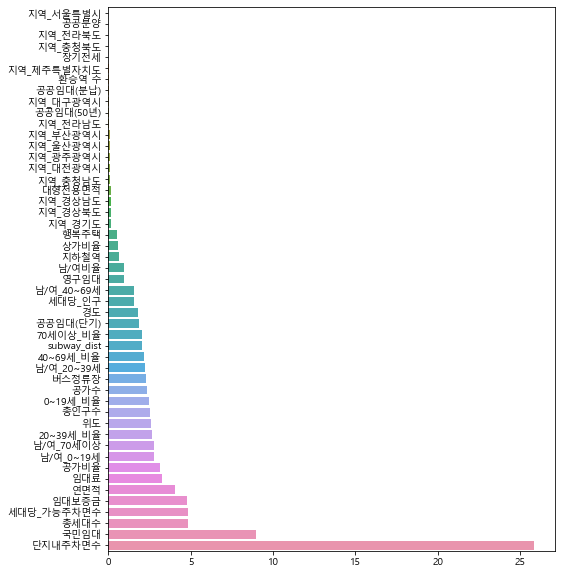

In [38]:
plt.figure(figsize=(8,10))
sns.barplot(y = X.columns[np.argsort(model_down.feature_importances_)], x = list(model_down.feature_importances_[np.argsort(model_down.feature_importances_)]))

### 2) train/test up

In [39]:
X = train_up.drop(columns=['단지코드','등록차량수','지역'],axis=1)
y = train_up['등록차량수']

models = [CatBoostRegressor(random_state=2021, loss_function = 'MAE')]

model_up,pred_up,error_up = fit_models(X, y, models, cv=True)
print('MAE : ',error_up)

MAE :  293.8326340239597


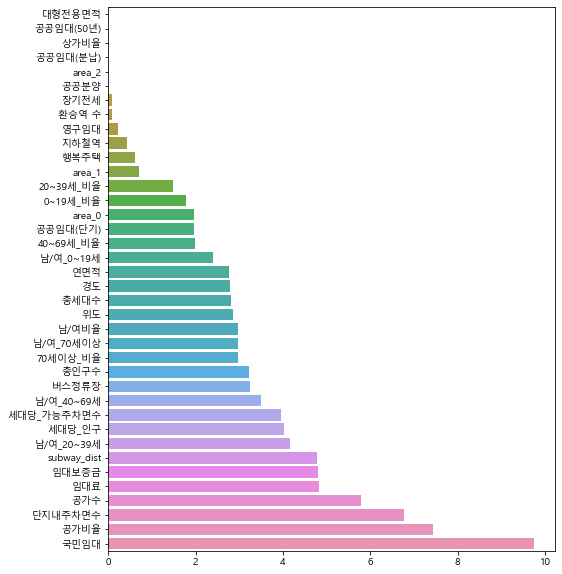

In [40]:
plt.figure(figsize=(8,10))
sns.barplot(y = X.columns[np.argsort(model_up.feature_importances_)], x = list(model_up.feature_importances_[np.argsort(model_up.feature_importances_)]))

## 4. Final prediction

In [133]:
col = ['총세대수', '공가수', '지하철역', '버스정류장', '단지내주차면수', '연면적', '위도', '경도',
       'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
       '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '상가비율', '세대당_가능주차면수', '공가수비율', '국민임대', '영구임대',
       '공공임대(단기)', '장기전세', '행복주택', '공공임대(분납)', '공공분양', '공공임대(50년)', '임대료',
       '임대보증금', '대형전용면적', '지역_경기도', '지역_경상남도', '지역_경상북도', '지역_광주광역시',
       '지역_대구광역시', '지역_대전광역시', '지역_부산광역시', '지역_서울특별시', '지역_세종특별자치시',
       '지역_울산광역시', '지역_전라남도', '지역_전라북도', '지역_제주특별자치도', '지역_충청남도', '지역_충청북도']

In [134]:
X_train = train_down.drop(columns=['단지코드','등록차량수'],axis=1)
X_train = pd.get_dummies(X_train, drop_first=True) 
X_train['지역_세종특별자치시'] = 0
X_train = X_train[col]
y_train = train_down['등록차량수']
X_test = test_down.drop(columns=['단지코드'],axis=1)
X_test = pd.get_dummies(X_test, drop_first=True) 
X_test['지역_서울특별시'] = 0
X_test = X_test[col]

In [136]:
X_train_f = pd.read_csv("X_train_f.csv")
(X_train_f!=X_train).sum()

총세대수             0
공가수              0
지하철역             0
버스정류장            0
단지내주차면수          0
연면적              0
위도               0
경도               0
subway_dist      0
환승역 수            0
총인구수             0
세대당_인구           0
남/여비율            0
남/여_0~19세        4
남/여_20~39세       0
남/여_40~69세       0
남/여_70세이상        0
0~19세_비율         0
20~39세_비율        0
40~69세_비율        0
70세이상_비율         0
상가비율             0
세대당_가능주차면수      52
공가비율           318
국민임대             0
영구임대             0
공공임대(단기)         0
장기전세             0
행복주택             0
공공임대(분납)         0
공공분양             0
공공임대(50년)        0
임대료             43
임대보증금           43
대형전용면적           0
지역_경기도           0
지역_경상남도          0
지역_경상북도          0
지역_광주광역시         0
지역_대구광역시         0
지역_대전광역시         0
지역_부산광역시         0
지역_서울특별시         0
지역_세종특별자치시       0
지역_울산광역시         0
지역_전라남도          0
지역_전라북도          0
지역_제주특별자치도       0
지역_충청남도          0
지역_충청북도          0
dtype: int64

In [62]:
cb_down = CatBoostRegressor(random_state=2021, 
#                             loss_function = 'MAE',
                            verbose=False).fit(X_train,y_train)
pred_down = cb_down.predict(X_test)

In [63]:
pred_down

array([ 751.14921254,  545.35290158,  518.92598618,  460.58450039,
        377.15908539,  310.36124722,  476.61904014,  238.27422762,
        430.7871469 ,  237.58921664,  263.12785724,  253.86237353,
        504.93406768,  364.53648426,  161.47297075,  719.72106868,
        270.97990621,  361.26545726,  399.65980943,  385.24055366,
        321.87804546,  177.28324374,   89.4777234 ,  533.73728335,
        529.17528961,  462.86711766,  195.7176067 ,  492.56455285,
        232.65905844,   88.32092176,  322.57399731,  355.18681191,
        607.45542753,  840.9259334 ,  247.56241888,  382.33825427,
        475.13489675,  457.6273267 ,  586.51367774,  860.38740873,
        480.97227738,  582.32491874,  406.01406748,  405.98746529,
        787.31683443,  322.48486224,  612.35240353,  623.53927912,
        255.06012274,  623.29230877,  271.99686458,  416.82792842,
        115.62078126,  291.33249082,  542.25292233,  810.84478345,
        375.02029972,  159.64380523,  301.26369979,  424.91090

In [330]:
X_train = train_up.drop(columns=['단지코드','등록차량수','지역'],axis=1)
y_train = train_up['등록차량수']
X_test = test_up.drop(columns=['단지코드','지역'],axis=1)

In [331]:
X_train = X_train[['총세대수', '공가수', '지하철역', '버스정류장', '단지내주차면수', '연면적', '위도', '경도',
       'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
       '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '상가비율', '세대당_가능주차면수', '공가수비율', '국민임대', '영구임대',
       '공공임대(단기)', '장기전세', '행복주택', '공공임대(분납)', '공공분양', '공공임대(50년)', '임대료',
       '임대보증금', '대형전용면적']]
X_test = X_test[['총세대수', '공가수', '지하철역', '버스정류장', '단지내주차면수', '연면적', '위도', '경도',
       'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
       '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '상가비율', '세대당_가능주차면수', '공가수비율', '행복주택', '영구임대',
       '국민임대', '공공임대(50년)', '공공임대(단기)', '공공임대(분납)', '임대료', '임대보증금', '대형전용면적',
       '공공분양', '장기전세']]

In [332]:
cb_up = CatBoostRegressor(random_state=2021, 
#                           loss_function = 'MAE',
                          verbose=False).fit(X_train,y_train)
pred_up = cb_up.predict(X_test)

In [333]:
def get_pred():
    res_down = pd.DataFrame()
    res_down['code'] = test_down['단지코드'].values
    res_down['num'] = pred_down
    res_up = pd.DataFrame()
    res_up['code'] = test_up['단지코드'].values
    res_up['num'] = pred_up 
    res = pd.concat([res_down,res_up],axis=0).reset_index(drop=True)
    return res_down, res_up, res

## 5. 기존 score와 비교 및 제출

In [334]:
def submit():
    res = get_pred()[2]
    res.loc[147,:] = ['C1327',0]
    res.loc[148,:] = ['C2335',0]
    res.loc[149,:] = ['C2675',0]
    return res

In [335]:
sub = submit()
sub.to_csv("result/result.csv",index=False)

In [77]:
def score(mse):
    score = pd.read_csv("result/MAE_"+str(mse)+".csv")
    score = pd.merge(score,get_pred()[2],on='code',how='inner')
    val = test_up['단지코드'].values
    score_up = score.loc[score['code'].isin(val),:]
    score_down = score.loc[-score['code'].isin(val),:] #y가 새롭게 예측
    mae = mean_absolute_error(score['num_x'],score['num_y'])
    mae_up = mean_absolute_error(score_up['num_x'],score_up['num_y'])
    mae_down = mean_absolute_error(score_down['num_x'],score_down['num_y'])
    print('전체 MAE : ',mae)
    print('큰 영역 MAE : ',mae_up)
    print('작은 영역 MAE : ',mae_down)
    return score

#### 리더보드 최고 점수(96)과 비교했을 때의 MAE가 30 이상인 경우
##### 상가비율 제거
전체 MAE :  31.320594550582037 <br>
큰 영역 MAE :  36.83649995247282 <br>
작은 영역 MAE :  30.501827342488866

##### 대형전용면적 dummy화
전체 MAE :  32.75355944938845 <br>
큰 영역 MAE :  36.83649995247282 <br>
작은 영역 MAE :  32.14749796846186

##### 환승역 수 제거
전체 MAE :  30.10305205300908 <br>
큰 영역 MAE :  36.20530567392698 <br>
작은 영역 MAE :  29.19724878115408

##### Baseline에서 중복 제거
전체 MAE :  33.14636205666477 <br>
큰 영역 MAE :  26.109495241972798 <br>
작은 영역 MAE :  34.190896974470604

##### Baseline
전체 MAE :  32.923810442487124 <br>
큰 영역 MAE :  36.83649995247282 <br>
작은 영역 MAE :  32.343020593348626

In [434]:
# 환승역 수 제거 X subway dist NA
res_dup_wo_NA = score(96)

전체 MAE :  27.631747118045446
큰 영역 MAE :  52.106995212372816
작은 영역 MAE :  23.99870247904373


In [243]:
# 환승역 수 제거 O subway dist NA
res_환승역_wo_NA = score(96)

전체 MAE :  23.046567626691793
큰 영역 MAE :  75.9762047953246
작은 영역 MAE :  15.189824609472863


In [315]:
# Base
res_base_dup_wo = score(96)

전체 MAE :  22.85814358738461
큰 영역 MAE :  66.57553686059872
작은 영역 MAE :  16.36884302339189


In [280]:
# 환승역 수 NA
res_환승역_wo_NA = score(96)

전체 MAE :  22.6105453925917
큰 영역 MAE :  67.41608062034977
작은 영역 MAE :  15.959723757221361


In [159]:
# Base 중복제거 (without loss function)
res_base_dup_wo = score(96)

전체 MAE :  23.093335921934816
큰 영역 MAE :  66.57553686059872
작은 영역 MAE :  16.63894672010189


In [514]:
# 환승역 수 제거(without loss function)
res_환승역_wo = score(96)

전체 MAE :  22.21942886241354
큰 영역 MAE :  67.05415358794829
작은 영역 MAE :  15.564274410966972


In [198]:
# Base(without loss function)
res_base_wo = score(96)

전체 MAE :  22.216293615441597
큰 영역 MAE :  64.67229789817362
작은 영역 MAE :  15.914230479723557


In [338]:
# Base(without loss function)
res_base = score(96)

전체 MAE :  23.117418727037304
큰 영역 MAE :  77.30399450487674
작은 영역 MAE :  15.074098885014266


In [337]:
res_base[['code','num_y']]

,code,num_y
0,C1072,751.149213
1,C1456,545.352902
2,C1840,518.925986
3,C1640,460.584500
4,C1377,377.159085
...,...,...
142,C1525,1292.610478
143,C2267,1075.791204
144,C1692,956.781953
145,C1570,883.077220


In [339]:
# tmp = pd.merge(res_base_wo[['code','num_y']],res_base[['code','num_x']],on='code')
# tmp.columns = ['단지코드','Base_wo','Base']

In [340]:
# tmp